In [1]:
import torch as tr
import numpy as np
from CSW import *

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
seed = 1
tr.manual_seed(seed)
np.random.seed(seed)

In [3]:
# task
taskL = [CSWTask(1),CSWTask(0)]

eval_pathL = [
  [0,10,1,3,5],       
  [0,11,2,3,6],
  ]

xeval = taskL[0].format_Xeval(eval_pathL)
xeval = tr.tensor(xeval)

# convenience 
softmax = lambda ulog: tr.softmax(ulog,-1)


In [4]:
def train_and_eval(stsize,learn_rate,block_len):
  """
  train network, and eval on paths from both graphs at
    every epoch of training.
  returns array with softmax prediction of network on each
    timestep of each path. 
  """
  neps = 200
  # init net, loss, optimizer
  net = CSWNet(stsize,seed)
  lossop = tr.nn.CrossEntropyLoss()
  optiop = tr.optim.Adam(net.parameters(), lr=learn_rate)
  # record y_softmax for on paths for graph A and B for each epoch of training
  tdim,sm_dim=5,12
  ysm = -np.ones([2,neps,tdim,sm_dim])
  ## train loop
  task_int = 0
  for ep in range(neps):
    # test phase: always interleaved
    if ep == 160: 
      block_len = 1
    # flip graph during training
    elif ep%block_len==0:
      task_int = (task_int+1)%2
      task = taskL[task_int]
      filler_id = 10+task_int 
    # forward prop  
    path = task.sample_path()
    xtrain,ytrain = task.dataset_onestory_with_marker(path=path,filler_id=filler_id,depth=1)
    yh = net(xtrain) # (time,smunits)
    # eval
    for idx,xev in enumerate(xeval):
      ysm_t = softmax(net(xev)).detach().numpy()
      ysm[idx,ep] = ysm_t
    # backprop
    for tstep in range(len(xtrain)):
      loss = lossop(yh[tstep].unsqueeze(0),ytrain[tstep])
      optiop.zero_grad()
      loss.backward(retain_graph=True)
      optiop.step()
  return ysm



### interleaved: good learning / blocked: catastrophic interference

In [5]:
stsize = 40
learn_rate = 0.01
block_len = 1
ysm_interleaved = train_and_eval(stsize,learn_rate,block_len=1)
ysm_blocked = train_and_eval(stsize,learn_rate,block_len=40)
print(ysm_interleaved.shape) 
# (graph,epoch,time_step,output_unit)

gru
gru
(2, 200, 5, 12)


# plot network predictions at each stage of both events

In [6]:
tstep_nodesL = [(10,11),(1,2),(3,4),(5,6)]
def plt_ysm(ysm):
  fig,axarr = plt.subplots(4,2,figsize=(20,16),sharex=True)
  for tstep in range(4):
    
    for graph_idx in range(2):
      ax = axarr[tstep,graph_idx]

      tonodes = tstep_nodesL[tstep]
      plt_ysm = ysm[graph_idx,:,tstep,tonodes].T
      ax.plot(plt_ysm,label=tonodes)

      input_path = eval_pathL[graph_idx][:tstep+1]
      ax.set_title('input:%s'%input_path)

      for block_t in range(0,201,40):
        ax.axvline(block_t,c='k',ls='--',lw=.3)
    axarr[tstep,0].legend(loc=1)

  axarr[3,0].set_ylabel('softmax pr')
  axarr[3,0].set_xlabel('epoch')
  

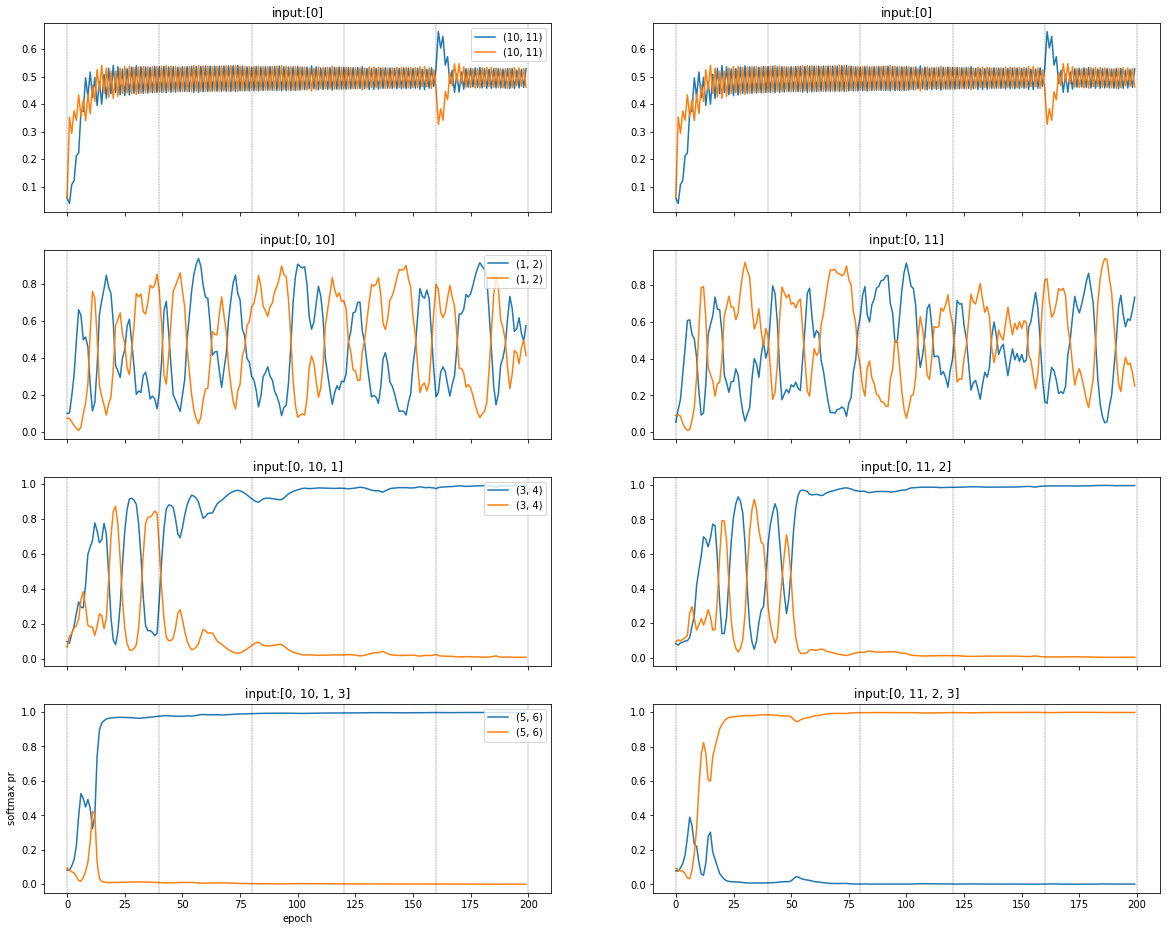

In [7]:
plt_ysm(ysm_interleaved)
plt.savefig('figures/ysm/ysm_intrlv-stsize%i-lr%.3f.png'%(stsize,learn_rate))

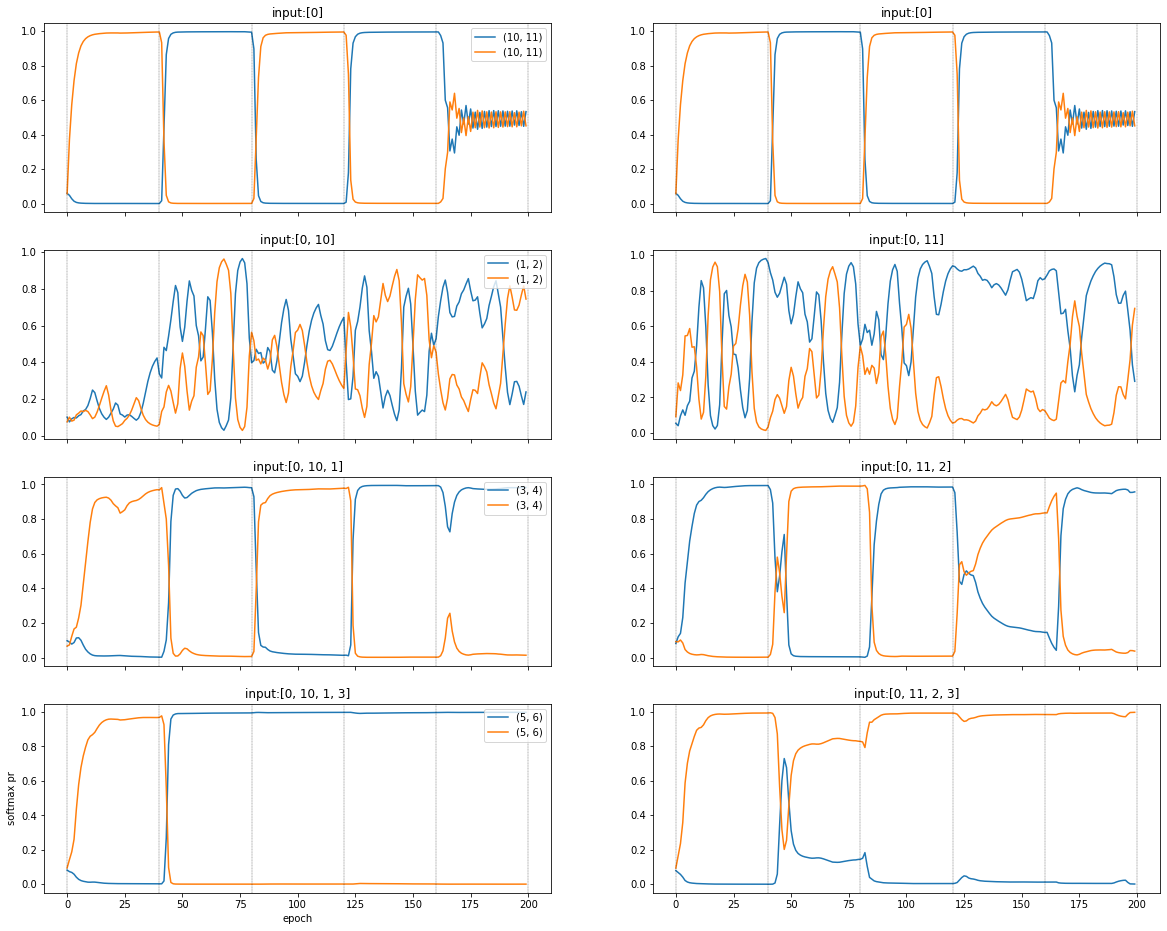

In [8]:
plt_ysm(ysm_blocked)
plt.savefig('figures/ysm/ysm_blocked-stsize%i-lr%.3f.png'%(stsize,learn_rate))